# Filter viral barcodes in transcripts
This notebook filters viral barcodes in 10X transcriptome data to remove UMIs that are likely derived from leaked transcripts.

## Notebook setup
Import python modules:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import kneed

import pandas as pd

import plotnine as p9

Get `snakemake` variables [as described here](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#jupyter-notebook-integration):

In [2]:
viral_tag_by_cell_csv = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial2_cell_barcodes_with_viral_tags.csv.gz'
viral_bc_by_cell_corrected_csv = 'results/viral_fastq10x/scProgenyProduction_trial2_viral_bc_by_cell_corrected.csv.gz'
expt = 'scProgenyProduction_trial2'
viral_bc_by_cell_filtered_csv = 'results/viral_fastq10x/scProgenyProduction_trial2_viral_bc_by_cell_filtered.csv.gz'
plot = 'results/viral_fastq10x/scProgenyProduction_trial2_viral_bc_by_cell_filtered.pdf'
barcoded_viral_genes = ['fluHA', 'fluNA']

## Organize data

Read the viral barcode UMI counts data into a pandas dataframe:

In [3]:
viral_bc_counts = pd.read_csv(viral_bc_by_cell_corrected_csv)
viral_bc_counts = (viral_bc_counts
                   .rename(columns={'count': 'bc_UMIs'}))
assert set(viral_bc_counts['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
display(viral_bc_counts)

,cell_barcode,gene,viral_barcode,bc_UMIs
0,AAACCCAAGTAGGTTA,fluHA,ACGTTATTGATTGAGA,1
1,AAACCCAAGTAGGTTA,fluHA,AGAATCGACACATGTC,14
2,AAACCCAAGTAGGTTA,fluHA,AGCCATAGTCTAAAGG,8
3,AAACCCAAGTAGGTTA,fluHA,AGGATGATTTTTTTGT,5
4,AAACCCAAGTAGGTTA,fluHA,CACGGATGGTGTACGA,12
...,...,...,...,...
55238,TTTGTTGCATGTGGTT,fluNA,TTCCTCAGCCTTTAAG,3
55239,TTTGTTGTCTAGGAAA,fluNA,GAACCCGATGGGGAAT,26
55240,TTTGTTGTCTAGGAAA,fluNA,TAAGGTAAAATAATAG,1
55241,TTTGTTGTCTAGGAAA,fluNA,TAAGGTATAATTCTAG,4


Read the total number of UMIs per cell into a pandas dataframe. Only keep relevant columns.

In [4]:
all_cells = pd.read_csv(viral_tag_by_cell_csv)
all_cells = all_cells[['cell_barcode',
                       'infected',
                       'infecting_viral_tag',
                       'total_UMIs',
                       'viral_UMIs',
                       'cellular_UMIs',
                       'frac_viral_UMIs']]
display(all_cells)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs
0,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901
1,AAACCCACAAGGCCTC,True,syn,10304,1485,8819,0.144119
2,AAACCCACACACACGC,True,both,7395,3320,4075,0.448952
3,AAACCCATCGTGCATA,True,syn,2764,1597,1167,0.577786
4,AAACCCATCTACTGCC,False,none,6313,3,6310,0.000475
...,...,...,...,...,...,...,...
7436,TTTGGTTGTTAAGCAA,False,none,8528,29,8499,0.003401
7437,TTTGGTTTCGTCGCTT,False,none,6492,6,6486,0.000924
7438,TTTGTTGCATGTGGTT,True,wt,3016,1680,1336,0.557029
7439,TTTGTTGTCGTCGGGT,False,none,11070,2,11068,0.000181


Sanity check that `total_UMIs` is equal to `viral_UMIs + cellular_UMIs`:

In [5]:
assert bool((all_cells['total_UMIs'] ==
             all_cells['viral_UMIs'] +
             all_cells['cellular_UMIs'])
            .all()), "UMI counts do not add up"

Merge dataframes:

In [6]:
viral_bc_frac = pd.merge(
                    left=pd.concat([all_cells.assign(gene=gene)
                                    for gene in barcoded_viral_genes]),
                    right=viral_bc_counts,
                    how='outer',
                    on=['cell_barcode', 'gene'],
                    validate='one_to_many')
assert (viral_bc_frac['cell_barcode'].unique() == \
    all_cells['cell_barcode'].unique()).all(), \
    "Cell barcodes in merged dataframe don't " \
    "match barcodes in source data."
assert viral_bc_frac['viral_barcode'].nunique() == \
    viral_bc_counts['viral_barcode'].nunique(), \
    "Number of viral barcodes in merged dataframe don't " \
    "match number of barcodes in source data."

# Make `infecting_viral_tag` column ordered category
viral_bc_frac['infecting_viral_tag'] = (viral_bc_frac['infecting_viral_tag']
                                        .astype('category')
                                        .cat
                                        .reorder_categories(['none',
                                                             'wt',
                                                             'syn',
                                                             'both']))

display(viral_bc_frac)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,gene,viral_barcode,bc_UMIs
0,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,ACGTTATTGATTGAGA,1.0
1,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGAATCGACACATGTC,14.0
2,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGCCATAGTCTAAAGG,8.0
3,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGGATGATTTTTTTGT,5.0
4,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,CACGGATGGTGTACGA,12.0
...,...,...,...,...,...,...,...,...,...,...
58922,TTTGTTGTCGTCGGGT,False,none,11070,2,11068,0.000181,fluNA,NaN,NaN
58923,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,GAACCCGATGGGGAAT,26.0
58924,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,TAAGGTAAAATAATAG,1.0
58925,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,TAAGGTATAATTCTAG,4.0


Calculate **each barcode's** fraction of all UMIs per cell:

In [7]:
viral_bc_frac['frac_bc_UMIs'] = (viral_bc_frac['bc_UMIs'] /
                                 viral_bc_frac['total_UMIs'])

display(viral_bc_frac)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,gene,viral_barcode,bc_UMIs,frac_bc_UMIs
0,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,ACGTTATTGATTGAGA,1.0,0.000186
1,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGAATCGACACATGTC,14.0,0.002609
2,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGCCATAGTCTAAAGG,8.0,0.001491
3,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGGATGATTTTTTTGT,5.0,0.000932
4,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,CACGGATGGTGTACGA,12.0,0.002236
...,...,...,...,...,...,...,...,...,...,...,...
58922,TTTGTTGTCGTCGGGT,False,none,11070,2,11068,0.000181,fluNA,NaN,NaN,NaN
58923,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,GAACCCGATGGGGAAT,26.0,0.009800
58924,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,TAAGGTAAAATAATAG,1.0,0.000377
58925,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,TAAGGTATAATTCTAG,4.0,0.001508


Sum total number of barcoded UMIs per cell-gene combination:

In [8]:
viral_bc_frac = (
    viral_bc_frac
    .assign(
        bc_UMIs=lambda x: x['bc_UMIs'].fillna(0),
        cell_gene_total_bc_UMIs=(lambda x:
                                 (x.groupby(
                                      ['cell_barcode',
                                       'gene'])
                                  ['bc_UMIs'])
                                 .transform('sum'))))

display(viral_bc_frac)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,gene,viral_barcode,bc_UMIs,frac_bc_UMIs,cell_gene_total_bc_UMIs
0,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,ACGTTATTGATTGAGA,1.0,0.000186,116.0
1,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGAATCGACACATGTC,14.0,0.002609,116.0
2,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGCCATAGTCTAAAGG,8.0,0.001491,116.0
3,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGGATGATTTTTTTGT,5.0,0.000932,116.0
4,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,CACGGATGGTGTACGA,12.0,0.002236,116.0
...,...,...,...,...,...,...,...,...,...,...,...,...
58922,TTTGTTGTCGTCGGGT,False,none,11070,2,11068,0.000181,fluNA,NaN,0.0,NaN,0.0
58923,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,GAACCCGATGGGGAAT,26.0,0.009800,36.0
58924,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,TAAGGTAAAATAATAG,1.0,0.000377,36.0
58925,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,TAAGGTATAATTCTAG,4.0,0.001508,36.0


Calculate fraction of all UMIs and fraction of viral UMIs that have barcode for each gene.

In [9]:
viral_bc_frac['frac_total_UMIs_wBC'] = (viral_bc_frac['cell_gene_total_bc_UMIs'] /
                                        viral_bc_frac['total_UMIs'])
viral_bc_frac['frac_viral_UMIs_wBC'] = (viral_bc_frac['cell_gene_total_bc_UMIs'] /
                                        viral_bc_frac['viral_UMIs'])
display(viral_bc_frac)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,gene,viral_barcode,bc_UMIs,frac_bc_UMIs,cell_gene_total_bc_UMIs,frac_total_UMIs_wBC,frac_viral_UMIs_wBC
0,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,ACGTTATTGATTGAGA,1.0,0.000186,116.0,0.021614,0.036639
1,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGAATCGACACATGTC,14.0,0.002609,116.0,0.021614,0.036639
2,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGCCATAGTCTAAAGG,8.0,0.001491,116.0,0.021614,0.036639
3,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,AGGATGATTTTTTTGT,5.0,0.000932,116.0,0.021614,0.036639
4,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901,fluHA,CACGGATGGTGTACGA,12.0,0.002236,116.0,0.021614,0.036639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58922,TTTGTTGTCGTCGGGT,False,none,11070,2,11068,0.000181,fluNA,NaN,0.0,NaN,0.0,0.000000,0.000000
58923,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,GAACCCGATGGGGAAT,26.0,0.009800,36.0,0.013570,0.035503
58924,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,TAAGGTAAAATAATAG,1.0,0.000377,36.0,0.013570,0.035503
58925,TTTGTTGTCTAGGAAA,True,wt,2653,1014,1639,0.382209,fluNA,TAAGGTATAATTCTAG,4.0,0.001508,36.0,0.013570,0.035503


## Plots
Set base plot style:

In [10]:
p9.theme_set(p9.theme_classic())

### Per cell metrics
Summary figures that address number and fraction of barcoded viral UMIs **in aggregate for each cell-gene combination**.

Plot number of viral barcode UMIs per cell-gene and fraction of all UMIs with viral barcode per cell.

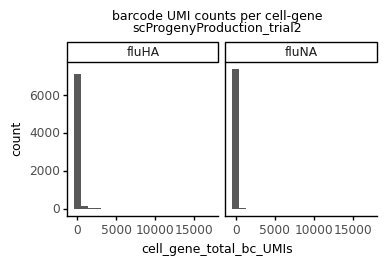

<ggplot: (8735626757325)>

In [46]:
fig = (p9.ggplot((viral_bc_frac
                  .drop_duplicates(subset=['cell_barcode', 'gene'])),
                 p9.aes(x='cell_gene_total_bc_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('~gene') +
       p9.ggtitle('barcode UMI counts per cell-gene\n'
                  f'{expt}') +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

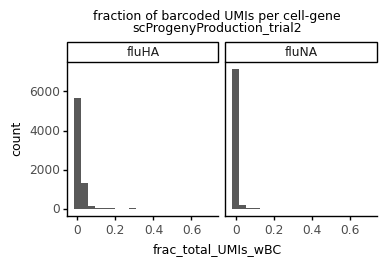

<ggplot: (8735627428283)>

In [49]:
fig = (p9.ggplot((viral_bc_frac
                  .drop_duplicates(subset=['cell_barcode', 'gene'])),
                 p9.aes(x='frac_total_UMIs_wBC')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('~gene') +
       p9.ggtitle('fraction of barcoded UMIs per cell-gene\n'
                  f'{expt}') +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Plot fraction of barcoded UMIs per cell-gene as a function of total UMI count:

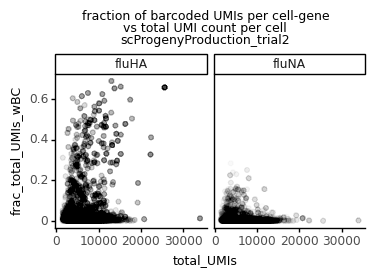

<ggplot: (8735631013572)>

In [56]:
fig = (p9.ggplot(viral_bc_frac,
                 p9.aes(x='total_UMIs',
                        y='frac_total_UMIs_wBC')) +
       p9.geom_point(alpha=0.01) +
       p9.facet_grid('~gene') +
       p9.ggtitle('fraction of barcoded UMIs per cell-gene\n'
                  'vs total UMI count per cell\n'
                  f'{expt}') +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Plot fraction of barcoded UMIs per cell-gene as a function of viral UMI count and fraction:

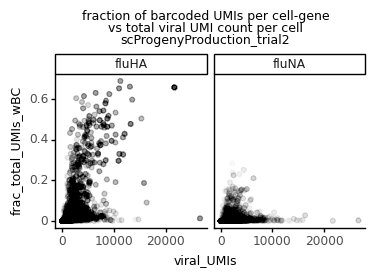

<ggplot: (8735617411407)>

In [61]:
fig = (p9.ggplot(viral_bc_frac,
                 p9.aes(x='viral_UMIs',
                        y='frac_total_UMIs_wBC')) +
       p9.geom_point(alpha=0.01) +
       p9.facet_grid('~gene') +
       p9.ggtitle('fraction of barcoded UMIs per cell-gene\n'
                  'vs total viral UMI count per cell\n'
                  f'{expt}') +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

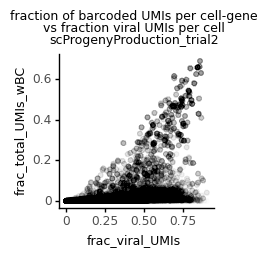

<ggplot: (8735616888998)>

In [62]:
fig = (p9.ggplot(viral_bc_frac,
                 p9.aes(x='frac_viral_UMIs',
                        y='frac_total_UMIs_wBC')) +
       p9.geom_point(alpha=0.01) +
       p9.ggtitle('fraction of barcoded UMIs per cell-gene\n'
                  'vs fraction viral UMIs per cell\n'
                  f'{expt}') +
       p9.theme(figure_size=(2, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Plot relationship between viral UMI fraction and fraction of viral UMIs with barcode:

In [ ]:
fig = (p9.ggplot((viral_bc_frac
                  .groupby('cell_barcode')
                  .max()
                  .reset_index()), p9.aes(x='frac_viral_UMIs',
                                          y='frac_viral_UMIs_wBC')) +
       p9.geom_point(alpha=0.3) +
       p9.ggtitle('fraction of barcoded UMIs per cell\n'
                  'vs fraction barcoded UMIs in viral UMIs\n'
                  f'{expt}') +
       p9.theme(figure_size=(2, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

### Per barcode metrics
Figures that show the outcomes **for each barcode individually.**

Plot distribution of each barcode's fraction of a cell's total UMIs.

In [ ]:
fig = (p9.ggplot(viral_bc_frac, p9.aes(x='frac_bc_UMIs',
                                       fill='infecting_viral_tag')) +
       p9.geom_histogram(bins=200, position='stack') +
       p9.facet_grid('infecting_viral_tag~') +
       p9.ggtitle('fraction of all UMIs in cell\n'
                  'from each viral barcode\n'
                  f'{expt}') +
       p9.scale_y_log10() +
       p9.theme(figure_size=(5,
                             1*viral_bc_frac['infecting_viral_tag'].nunique()),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

In [ ]:
fig = (p9.ggplot(viral_bc_frac, p9.aes(x='frac_bc_UMIs',
                                       y='frac_viral_UMIs',
                                       color='infecting_viral_tag')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('infecting_viral_tag~') +
       p9.ggtitle('fraction of all UMIs in cell\n'
                  'from each viral barcode\n'
                  'vs fraction of viral UMIs in that cell\n'
                  f'{expt}') +
       p9.scale_y_log10() +
       p9.scale_x_log10() +
       p9.theme(figure_size=(4,
                             2*viral_bc_frac['infected'].nunique()),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(CBPALETTE[0:]))
display(fig)

### Knee plots

Rank order barcodes by fraction of total UMIs in their cell:

In [ ]:
viral_bc_frac = (viral_bc_frac
                 .sort_values('frac_bc_UMIs', ascending=True)
                 .reset_index(drop=True))

viral_bc_frac = (viral_bc_frac
                 .assign(bc_rank=lambda x: (x['frac_bc_UMIs']
                                            .rank(method='first',
                                                  ascending=True))))

display(viral_bc_frac)

Calculate knee using [kneed](https://pypi.org/project/kneed/) package:

In [ ]:
kl = kneed.KneeLocator(x=viral_bc_frac['bc_rank'].tolist(),
                       y=viral_bc_frac['frac_bc_UMIs'].tolist(),
                       curve='convex',
                       direction='increasing',
                       S=10
                       )

viral_bc_frac['below_knee'] = viral_bc_frac['frac_bc_UMIs'] <= kl.knee_y

display(viral_bc_frac)

print(f'knee rank: {kl.knee}')
print(f'fraction of all UMIs at knee: {kl.knee_y}')
print(f'barcodes retained: {len(viral_bc_frac.query("below_knee == False"))}')

Plot knee plot of each barcode's fraction of all UMIs in cell:

In [ ]:
fig = (p9.ggplot(viral_bc_frac, p9.aes(x='bc_rank',
                                       y='frac_bc_UMIs',
                                       color='infecting_viral_tag')) +
       p9.geom_point() +
       p9.geom_vline(xintercept=kl.knee,
                     linetype='dashed',
                     color='#3A3B3C',
                     size=0.5) +
       p9.facet_grid('~infected') +
       p9.ggtitle('knee plot of viral barcodes\n'
                  'fraction of all UMIs in cell\n'
                  f'{expt}') +
       p9.xlab('barcode fraction rank') +
       p9.ylab('fraction of all UMIs in cell\n'
               'assigned to barcode') +
       p9.theme(figure_size=(6, 2),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(CBPALETTE[0:]))

display(fig)

Break the plot out by infecting viral tag and viral gene:

In [ ]:
fig = (p9.ggplot(viral_bc_frac, p9.aes(x='bc_rank',
                                       y='frac_bc_UMIs',
                                       color='below_knee')) +
       p9.geom_point() +
       p9.geom_vline(xintercept=kl.knee,
                     linetype='dashed',
                     color='#3A3B3C',
                     size=0.5) +
       p9.facet_grid('infecting_viral_tag~gene') +
       p9.ggtitle('knee plot of viral barcodes\n'
                  'fraction of all UMIs in cell\n'
                  f'{expt}') +
       p9.xlab('barcode fraction rank') +
       p9.ylab('fraction of all UMIs in cell\n'
               'assigned to barcode') +
       p9.theme(figure_size=(6, 5),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(CBPALETTE[0:]))

display(fig)

In [ ]:
#  Temporary cell to create files expected by snakemake.
#  Not final version

print(f"Saving plots to {plot}")
p9.ggsave(plot=fig, filename=plot, verbose=False)

print(f"Saving filtered barcodes to {viral_bc_by_cell_filtered_csv}")
viral_bc_frac = (viral_bc_frac
                 .query('viral_barcode != "none"')
                 [['cell_barcode',
                   'gene',
                   'frac_bc_UMIs']]
                 .drop_duplicates()
                 .rename(columns={'mean_freq_corrected_bc':
                                  'freq'}))


viral_bc_frac.to_csv(viral_bc_by_cell_filtered_csv,
                     columns=['cell_barcode',
                              'gene',
                              'frac_bc_UMIs'],
                     index=False)

### 